In [16]:
!pip install dateparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.8/293.8 kB 5.3 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateparser

In [127]:
PATH = '/content/data.xlsx'
df = pd.read_excel(PATH)

In [128]:
# remove duplicated rows
df = df.drop_duplicates()
len(df[df.duplicated()])
# drop ВНУТРЕННИЙ
df = df.drop(1)
# fill nan in document -> НЕТ
df.document = df.document.fillna('НЕТ')

In [129]:
# remove nan rows and make date column
df_nan = df[~df['status'].isin(['ВНУТРЕННИЙ', 'ОПЛАЧЕНО', 'ПРОСРОЧЕНО', 'В РАБОТЕ', 'НА ПОДПИСАНИИ'])]

df['date'] = np.NaN
list_index = df_nan.index.to_list()
list_index.append(max(df.index))

for i in range(1, len(list_index)):
    first = list_index[i-1]
    second = list_index[i]
    df.loc[first:second, 'date'] = df.loc[first, 'status']

df = df.drop(df_nan.index.to_list())
df.dropna(how='all', axis=1, inplace=True)

* 1) Вычислите общую выручку за июль 2021 по тем сделкам, приход денежных
средств которых не просрочен.

In [130]:
res1 = df['sum'][(~df['document'].isin(['ПРОСРОЧЕНО'])) & (df['date'] == 'Июль 2021')].sum()
print(f'выручка за июль 2021 = {np.round(res1,2)}')

выручка за июль 2021 = 828600.37



* 2) Как изменялась выручка компании за рассматриваемый период?
Проиллюстрируйте графиком.

In [136]:
df['month_date'] = df['date'].apply(lambda x: dateparser.parse(x)).dt.month
df_sum_month = df.groupby(['month_date'])["sum"].sum().reset_index().sort_values(by='month_date', ascending=True)
df_sum_month['month'] = df_sum_month['month_date'].replace({5: 'May',
                                                            6: 'June',
                                                            7:'July',
                                                            8: 'August',
                                                            9: 'September',
                                                            10: 'November'})

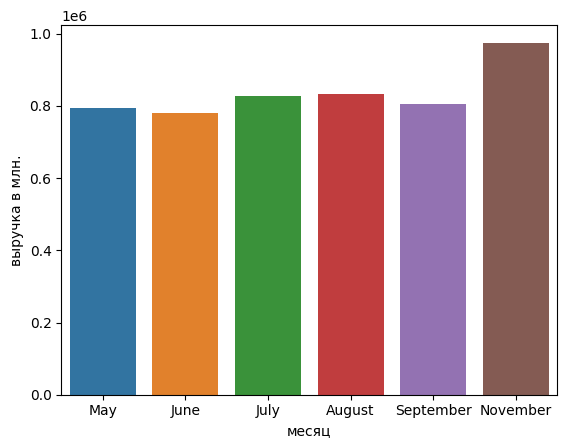

In [137]:
ax = sns.barplot(data=df_sum_month, x="month", y="sum")
ax.set(xlabel='месяц', ylabel='выручка в млн.')
plt.show()

* 3) Кто из менеджеров привлек для компании больше всего денежных средств в
сентябре 2021?

In [138]:
df.query("date == 'Сентябрь 2021'").groupby(['sale'])["sum"].sum().reset_index().sort_values(by=['sum'], ascending=False)

,sale,sum
6,Смирнов,212084.60
5,Петрова,145890.76
0,Андреев,132646.30
2,Иванов,94770.60
3,Кузнецова,72228.40
8,Филимонова,59514.47
1,Васильев,49895.45
7,Соколов,35183.50
4,Михайлов,4268.70


* 4) Какой тип сделок (новая/текущая) был преобладающим в октябре 2021?

In [139]:
df['new/current'][(df['date'] == 'Октябрь 2021')].value_counts()

текущая    95
новая      35
Name: new/current, dtype: int64

* 5) Сколько оригиналов договора по майским сделкам было получено в июне 2021?

In [140]:
len(df[(df['document'] == 'оригинал') &
   (df['date'] == 'Май 2021') &
   (pd.to_datetime(df['receiving_date']).dt.month ==6)])

76

Вычислите остаток каждого из менеджеров на 01.07.2021.

In [141]:
def first_condition(row) -> bool:
    """
    За новые сделки менеджер получает 7 % от суммы, при условии, что статус
    оплаты «ОПЛАЧЕНО», а также имеется оригинал подписанного договора с клиентом
    (в рассматриваемом месяце).
    """
    if (row['status'] == 'ОПЛАЧЕНО') & (row['document'] == 'оригинал') & (row['new/current'] == 'новая'):
      return True
    else:
      return False

def second_condition(row) -> bool:
    """
    За текущие сделки менеджер получает 5 % от суммы, если она больше 10 тыс.,
    и 3 % от суммы, если меньше. При этом статус оплаты может быть любым,
    кроме «ПРОСРОЧЕНО»,а также необходимо наличие оригинала подписанного договора
    с клиентом (в рассматриваемом месяце).
    """
    if(row['new/current']	 == 'текущая') & (row['document'] == 'оригинал'):
      return True
    elif row['status'] == 'ПРОСРОЧЕНО':
      return False
    else:
      return False

In [142]:
from dataclasses import dataclass, field
from typing import Dict


@dataclass
class Manager:
  name: str
  month: int
  bonus_history: Dict[int, float] =field(default_factory= lambda: {})
  bonus_current_month: float = 0

  @property
  def bonus_current(self)-> float:
    return self.bonus_current_month
  @bonus_current.setter
  def bonus_current(self, value: float) -> None:
    self.bonus_current_month += value



In [143]:
dict_managers = dict()
for index, row in df.iterrows():
    value = 0
    person = row['sale']

    # current or next month
    current_month = row['month_date']
    receiv_month = pd.to_datetime(row['receiving_date']).month
    # create person
    if person not in dict_managers:
      dict_managers[person] = Manager(name = row['sale'],
                                      month = row['month_date'],
                                      )
    # selected manager
    selected_manager = dict_managers.get(person)

    # check first condition
    if first_condition(row): # true or false
      value = row['sum'] * 0.07

    # check second condition
    if second_condition(row): # true or false
      if row['sum'] > 1e4:
        value = row['sum'] * 0.05
      elif row['sum'] < 1e4:
        value = row['sum'] * 0.03


    # check when manager get bonus
    if current_month == selected_manager.month:
      selected_manager.bonus_current = value

    elif current_month != selected_manager.month:
      # if not exist month, then create
      if selected_manager.bonus_history.get(receiv_month) is None:
        selected_manager.bonus_history[receiv_month] = 0
      selected_manager.bonus_history[receiv_month] += value


    # if time change on next month
    if current_month != selected_manager.month:
            # остаток на 01 июля
      if (current_month == 7)& (selected_manager.month==6):
        print(f'{selected_manager.name}, остаток на 01 июля = {selected_manager.bonus_history.get(7, 0)}')

      selected_manager.bonus_history[selected_manager.month] = np.around(selected_manager.bonus_current_month, 2)
      # get bonus from next month
      selected_manager.bonus_current_month = selected_manager.bonus_history.get(current_month)
      # if month not exist, then bonus 0
      if selected_manager.bonus_current_month is None:
         selected_manager.bonus_current_month = 0
      # replace current month
      selected_manager.month = current_month



Иванов, остаток на 01 июля = 675.9350000000001
Кузнецова, остаток на 01 июля = 0
Андреев, остаток на 01 июля = 268.011
Филимонова, остаток на 01 июля = 0
Соколов, остаток на 01 июля = 0
Смирнов, остаток на 01 июля = 83.961
Петрова, остаток на 01 июля = 0
Селиванов, остаток на 01 июля = 253.61100000000002
Васильев, остаток на 01 июля = 0
